# **FICO Analytic Challenge © Fair Isaac 2024**

# Week 10: Performance Metrics on Blind Holdout Set

## Model Performance Metrics Importance

In the past weeks we introduced Logistic Regression, Neural Networks, inference and explainability. This week we'll focus on model performance.

In the credit fraud detection world, our primary goal is to accurately identify fraudulent activities while minimizing the impact on genuine transactions. To achieve this, we rely on machine learning models to sift through the vast amounts of transaction data and flag suspicious activities. But how do we know if our models are effective? This is where model performance metrics come into play, serving as vital tools to evaluate and compare the effectiveness of our models. This week, we'll dive into why these metrics are crucial and why, in the fraud detection industry, we often need to develop specific metrics to ensure we deliver the best models that provide the highest value to our clients.

### Why Model Performance Metrics Matter

- **True Positive Rate (TPR)** measures how well the model is correctly identifying actual cases of fraud.
- **False Positive Rate (FPR)** shows how often the model incorrectly labels normal transactions as fraud.

These metrics help us understand the trade-offs between catching fraudsters and avoiding unnecessary disruptions for genuine customers.

### Custom Metrics: Necessity for Accurate Evaluation

Credit fraud detection models are often evaluated using neural networks, where the predictions are presented as scores typically ranging from 1 to 1000. These scores help us rank transactions by their likelihood of being fraud. However, comparing scores from different models can be tricky. Each model might assign scores differently, making it hard to directly compare one model’s scoring to another’s.

To address this, we need to create metrics that can compare models more holistically. One approach is to use cumulative gain or lift charts, which show the what percentage of fraud is caught as we move through the score range. By comparing the areas under these curves, we can get a better sense of overall performance.

Additionally, creating metrics that account for the specific cost-benefit scenarios of our use case can ensure that we are making informed decisions. By developing custom metrics and carefully evaluating score distributions, we can make sure our models are not just effective but also finely tuned for catching real-world credit fraud.

In the fraud detection field, there are industry standard performance metrics that give meaningful insight. We'll focus on a few key performance metrics that are especially useful for understanding these models.

## False-Positive and Detection Rates
- Assessing the performance of a model is a matter of performing a cost-benefit analysis.
- The cost involves the number of false positives (FP), which are normal transactions mistakenly tagged as fraud. The benefit is correct fraud predictions and the reduction in fraud losses achieved by acting upon those predictions.
- Ideally, we want our model to increase the number of correct fraud predictions without raising, or even reducing, the number of false positives.
- If a model scores at least one transaction on a fraud account above a suspect threshold score, that fraudulent account is considered to be detected.

### Transaction Based Metrics
- **Percent Non-Fraud (%NF):** False positives are measured using a Percent Non-Fraud metric.
    - This percentage is the number of transactions from non-fraud accounts that scored above our suspect threashold, divided by the total number of transactions from these non-fraud accounts.
    - As the threshold score increases, the number of false positives decreases, but also reduces the number of actual frauds detected.
      - For instance, if a bank raises the threshold to reduce false alarms, they might also miss catching some genuine fraud cases.
- **Transaction Value Detection Rate (TVDR):** This percentage shows us how much money involved in fraud transactions is caught by our model. It looks at the transactions that score above a certain threshold and calculates what percentage of the total fraud amount these represent.
  - For example, if 100k of fraudulent transactions occur and the model identifies 80k of it, the TVDR would be 80%.
- **Transaction Detection Rate (TDR) or Percent Fraud (%F):** The percentage of fraud transactions with scores above a score threshold.
    - If there are 100 fraud transactions, and the model correctly identifies 72 of them, the TDR is 72 percent.

### Account Based Metrics
- **Account Percent Non-Fraud (A%NF):** Similar to %NF but at the account level, this measures the number of non-fraud accounts that score above the threshold, divided by the total number of non-fraud accounts. This helps in understanding how often legitimate accounts are mistakenly flagged as suspicious.
- **Account Detection Rate (ADR):**  The percentage of correctly identified fraud accounts. This is calculated by taking the Number of frauds accounts correctly detected at or above some Score Threshold divided by total number of actual fraud accounts.
    - For example, if there are 100 fraud accounts and the model identifies 80, the ADR is 80%.
- **Value Detection Rate (VDR):** Sum value associated with frauds detected at some Score Threshold divided by the sum value associated with all frauds. Essentially, this tells us what fraction of the total fraudulent dollars was successfully identified by the model.
  - For example, if the total amount of fraud is 100k and the model catches frauds totaling 80k, the VDR would be 80%.
    - There are two types: OLVDR (on-line) and RTVDR (real-time)
- **Real-Time Value Detection Rate (RTVDR):** This measures the amount of money saved from correct fraud predictions, expressed as a percentage of the total amount fraudulently charged against accounts. Only amounts associated with approved fraud transactions are counted.
    - Lowering the threshold score generally improves RTVDR but may increase false positives, as more transactions are flagged as potential fraud.

## Types of Measurements

### Receiver Operating Characteristic (ROC) Curve
- Created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.
- Curves closer to the top-left corner indicate a better performance.
    - The diagonal line (FPR = TPR) represents a random classifier; the closer the curve is to this line, the less accurate the model.

### Area Under Curve (AUC)  
- Specifically, we’re looking at the area under the Receiver Operating Characteristic (ROC) curve.
- This area, ranging from 0 to 1, measures the ability of a classification model to separate the two classes and sift signal from noise.
- To first draw the ROC curve, we plot the True Positive Rate (TPR) against the False Positive Rate (FPR).

## Mount the Google Drive

In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

path = '/content/drive/MyDrive/FICO Analytic Challenge/'
sys.path.append(path +'Data')
sys.path.append(path +'Week_04')
sys.path.append(path +'Week_06')
sys.path.append(path +'Week_07')
sys.path.append(path +'Week_10')
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/FICO Analytic Challenge


### Import the required libraries

In [2]:
# import the necessary libaries
import numpy as np
import pandas as pd
from pickle import dump, load
from fico_functions import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Removing limitation in viewing pandas columns and rows
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [3]:
# path to model
mdlPath = f"{path}Model"

# Folder's name that's holding data of interest
data = 'Data'

# Model name; this will be used to distinguish model's output files
model='NNet'

# import scale file
scaleFile = os.path.join(path + data, 'scaler.' + model + '.' + data + ".pkl")

### Data location
- test_C_notags.csv is the blind holdout dataset
    - you should have already created the features for it and named it either of the following:
        - test_C_notags_features.csv
            - if only using features from week 4
        - test_C_notags_advanced_features.csv
            - if also using week 8
- score.NNet.test_C_notags_features.csv or score.NNet.test_C_notags_advanced_features.csv
    - this should have scores from your trained NNet model
    - this dataset doesn't have the following columns since it has "notags"
        - mdlIsFraudTrx
        - mdlIsFraudAcct
- score.NNet.test_C_features.csv or score.NNet.test_C_advanced_features.csv
    - this is the files name that we return to you which includes the tags

In [4]:
# Change to correct file name
blindholdoutFile = ['test_C']

# CSV filename suffex
featureTestFileSuffix="_advanced_features.csv"

# Scored Blind Holdout file location
blindholdoutCSV = os.path.join(path + data, 'score.' + model + '.' + blindholdoutFile[0] + featureTestFileSuffix)

if not os.path.isfile(blindholdoutCSV):
    featureTestFileSuffix="_features.csv"
    blindholdoutCSV = os.path.join(path + data, 'score.' + model + '.' + blindholdoutFile[0] + featureTestFileSuffix)

In [5]:
# test dataset
df_test = import_df(blindholdoutCSV)

In [6]:
df_test.head()

,lat,category,transactionDateTime,cardholderCountry,pan,city_pop,trans_num,street,merchCountry,is_train,gender,zip,merchant,long,last,first,job,merch_long,cardholderState,dob,unix_time,merchState,transactionAmount,deltaTime,merch_lat,1m,AvgTransactionAmount_Last7Days,CNP_High,HighValue_International,IS_0_TO_5AM,IsHighValue,IsSpent,IsTransaction,Is_High_Low,RelativeAmount,amount_diff,amt_trend_24h,amt_trend_5e,average_spending,category_ratio,count_trend_1h,ewm_1D,high_interaction,is_cnp,is_grocery_pos,is_international,is_late_night,is_travel,monday_buy,num_hi_amt_last_hour,num_last_24_hours,outside_country,outside_state_purchase,ratio_14D_to_60D,ratio_30D_to_60D,repeat_amt,repeat_hi_amt_1H,rolling_mean_14D,rolling_mean_30D,rolling_mean_60D,spending_above_threshold,spending_below_avg_20,transactionHour,transactionHour_Risk,user_avg_amount,y_preds,score,mdlIsFraudTrx,mdlIsFraudAcct
0,26.7832,gas_transport,2020-05-04 09:58:28,US,0002898353840886A,459921,c772e20a62ce9e1aaef80a9d6f8e14ed,92213 Lee Well,US,0,M,33404,Brekke and Sons,-80.0638,Copeland,Charles,"Administrator, arts",-79.915949,Florida,1969-09-08,1325671108,Florida,68.22,0.0,25.784525,68.22,68.220000,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.000000,0.00,68.220,0.000,81.746804,0.0,1.0,68.220000,1.110223e-16,0.0,0.0,0.0,0.0,0.0,0.0,-5.551115e-17,1.0,0.0,0.0,1.0,1.0,-5.421011e-20,68.22,68.220000,68.220000,68.220000,0.0,0.0,9.0,0.0,0.000000,0.000112,15,NaN,NaN
1,26.7832,entertainment,2020-05-05 08:58:09,US,0002898353840886A,459921,14256aa985f72b9ef6a198efba2cfc1f,92213 Lee Well,BS,0,M,33404,Douglas-White,-80.0638,Copeland,Charles,"Administrator, arts",-79.473664,Florida,1969-09-08,1325753889,West Grand Bahama,4.03,82781.0,26.367189,4.03,36.125000,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.059074,-64.19,36.125,0.000,81.746804,0.0,1.0,36.125000,1.000000e+00,0.0,0.0,1.0,0.0,0.0,1.0,-5.551115e-17,2.0,1.0,1.0,1.0,1.0,-5.421011e-20,4.03,36.125000,36.125000,36.125000,0.0,1.0,8.0,0.0,68.220000,0.001104,178,NaN,NaN
2,26.7832,travel,2020-05-05 17:31:26,US,0002898353840886A,459921,0718d61a07e2cfe420818b653fc31d6b,92213 Lee Well,US,0,M,33404,"Ritchie, Oberbrunner and Cremin",-80.0638,Copeland,Charles,"Administrator, arts",-80.743962,Florida,1969-09-08,1325784686,Florida,3.43,30797.0,26.459335,3.43,25.226667,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.094948,-0.60,3.730,0.000,81.746804,0.0,1.0,19.777500,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,-5.551115e-17,2.0,0.0,0.0,1.0,1.0,-5.421011e-20,3.43,25.226667,25.226667,25.226667,0.0,1.0,17.0,0.0,36.125000,0.000641,139,NaN,NaN
3,26.7832,grocery_pos,2020-05-07 02:39:08,US,0002898353840886A,459921,d44aeb589ba8e2d58ba320fe1ecf139b,92213 Lee Well,US,0,M,33404,"Schumm, Bauch and Ondricka",-80.0638,Copeland,Charles,"Administrator, arts",-80.267861,Florida,1969-09-08,1325903948,Florida,59.77,119262.0,26.817313,59.77,33.862500,0.0,0.0,1.0,0.0,1.0,1.0,-1.0,2.369318,56.34,59.770,0.000,81.746804,0.0,1.0,39.773750,1.000000e+00,0.0,1.0,0.0,1.0,0.0,0.0,-5.551115e-17,1.0,0.0,0.0,1.0,1.0,-5.421011e-20,59.77,33.862500,33.862500,33.862500,0.0,1.0,2.0,1.0,25.226667,0.364592,621,NaN,NaN
4,26.7832,entertainment,2020-05-07 11:53:26,US,0002898353840886A,459921,139db024ddf70d4b8b76a896c504aa75,92213 Lee Well,US,0,M,33404,"Welch, Rath and Koepp",-80.0638,Copeland,Charles,"Administrator, arts",-80.339584,Florida,1969-09-08,1325937206,Florida,73.06,33258.0,27.220689,73.06,41.702000,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,2.157549,13.29,66.415,41.702,81.746804,0.0,1.0,56.416875,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,-5.551115e-17,2.0,0.0,0.0,1.0,1.0,-5.421011e-20,73.06,41.702000,41.702000,41.702000,0.0,0.0,11.0,0.0,33.862500,0.000237,68,NaN,NaN


### Removing Non-Fraud Transactions from Fraud Accounts

A fraud account will have transactions that are fraud and non-fraud. To ensure we dont have any uncertainty with a transaction being non-fraud or not in a fraud account, we remove the records that have non-fraud transaction from fraud accounts.

In [7]:
df_test = filterNFTrxfromFAccn(df_test)

In [8]:
df_test = matureProf_n_months(df_test, 'transactionDateTime', ['pan','transactionDateTime'], n_months=2)

In [9]:
print("\033[1mNNet\033[0m")
dataset_count(df_test, df_isTrain=False)

NNet
Test Set
# of Accounts = 261
# of Non-Fraud Accounts = 230
# of Fraud Accounts = 31
----------
# of Transactions = 4069
# of Non-Fraud Transactions = 4035
# of Fraud Transactions = 34
----------
Account Level Fraud Rate = 0.1188
Transaction level Fraud Rate = 0.0084
# of Fraud Transactions / # of Fraud Accounts = 1.0968


### Threshold Score Value
We're working with metrics that vary based on a threshold score. Our goal is to calculate these values for a specific range of threshold scores, which will then be used to generate the ROC plot. This can help reduce False Positives (FP) by adjusting final outputs to the desired Threshold Score where any transaction scoring at or above the threshold would be considered a fraud transaction.

In [10]:
# Getting a range of threshold scores
threshold_list = list(range(0,980, 5))
threshold_list.extend(range(980, 1000, 1))

# Removing any duplicated and sorting list
threshold_list = sorted(set(threshold_list))
# print(threshold_list)

## Calculate Test Sets Metrics

<font color='red'>(**Warning: Takes a long time**)</font>

In [11]:
# Dataset to calculate performance metrics for train and required columns
trainOrTest= 'test'
perfCols = ['pan', 'is_train', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionAmount', 'transactionDateTime', 'score']

In [12]:
pNF, TDR, TVDR, ApNF, ADR, RTVDR = calcMetrics(df_test[perfCols], threshold_list, model, df_isTrain=trainOrTest)

#### TDR vs %NF (**ROC**)

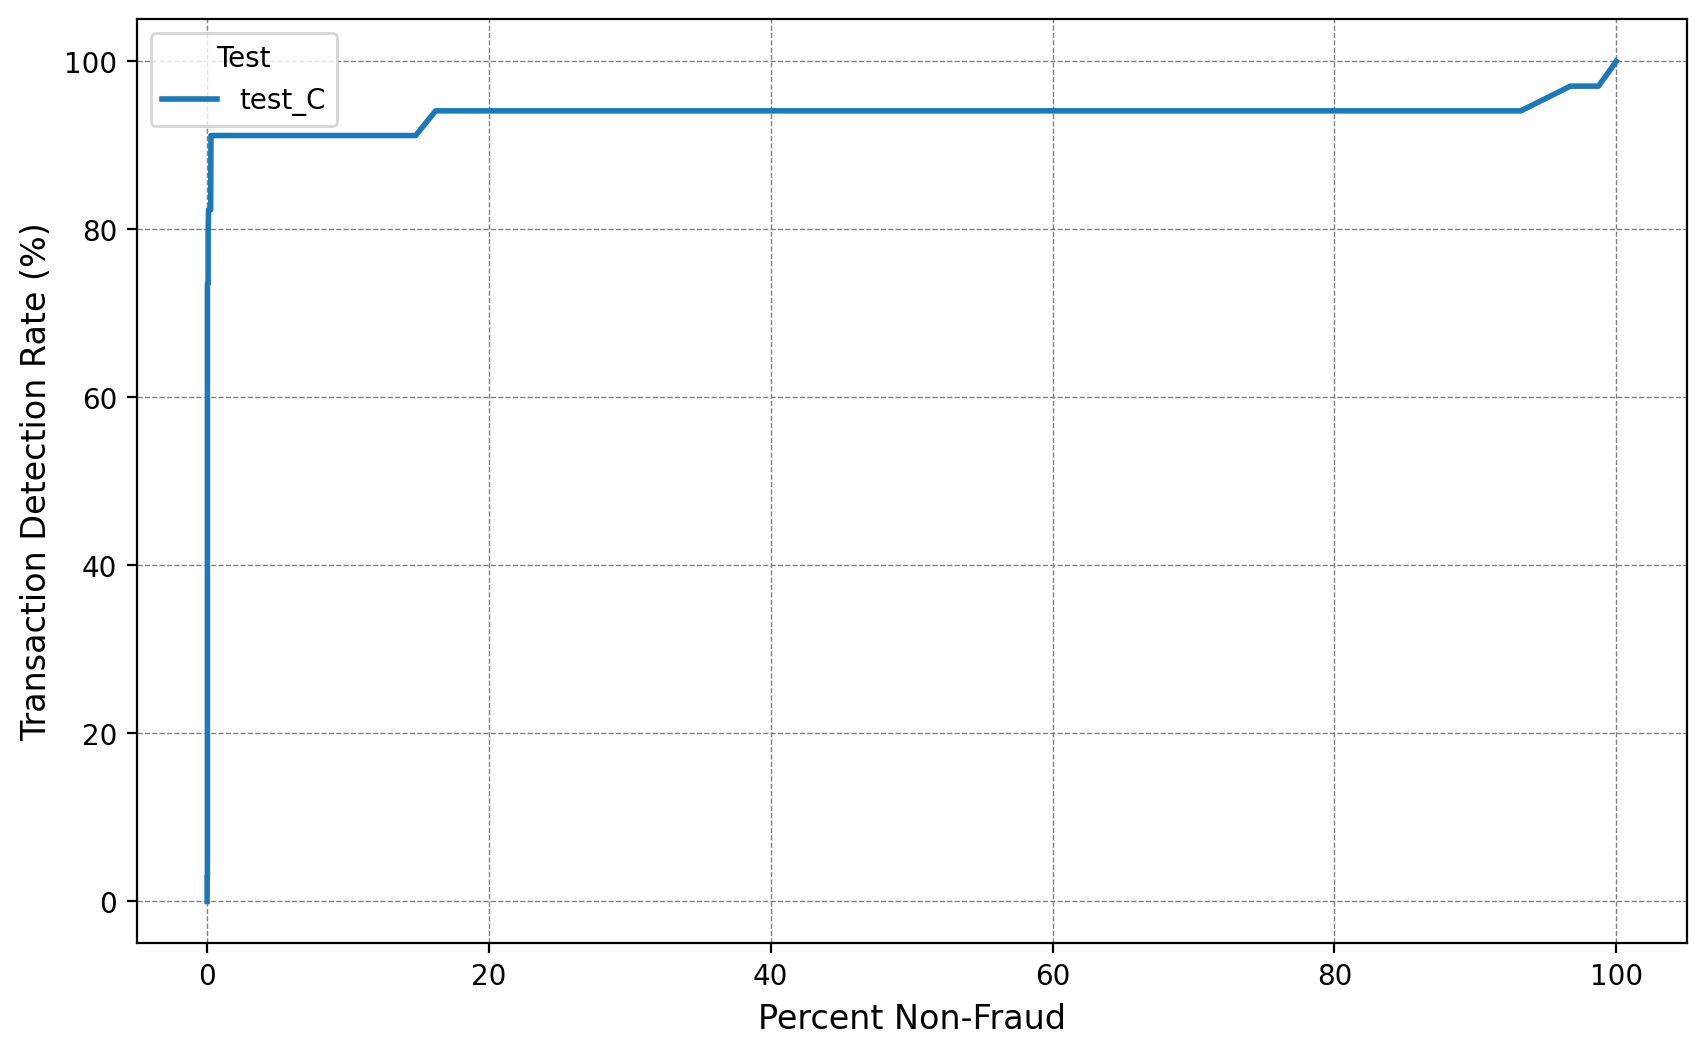

In [13]:
tdr_pNF = plot_roc_NNet(TDR, pNF, xlabel='Percent Non-Fraud', ylabel='Transaction Detection Rate (%)', f1=blindholdoutFile, legend=trainOrTest)

#### TVDR vs %NF (**Dollar Weighted ROC**)

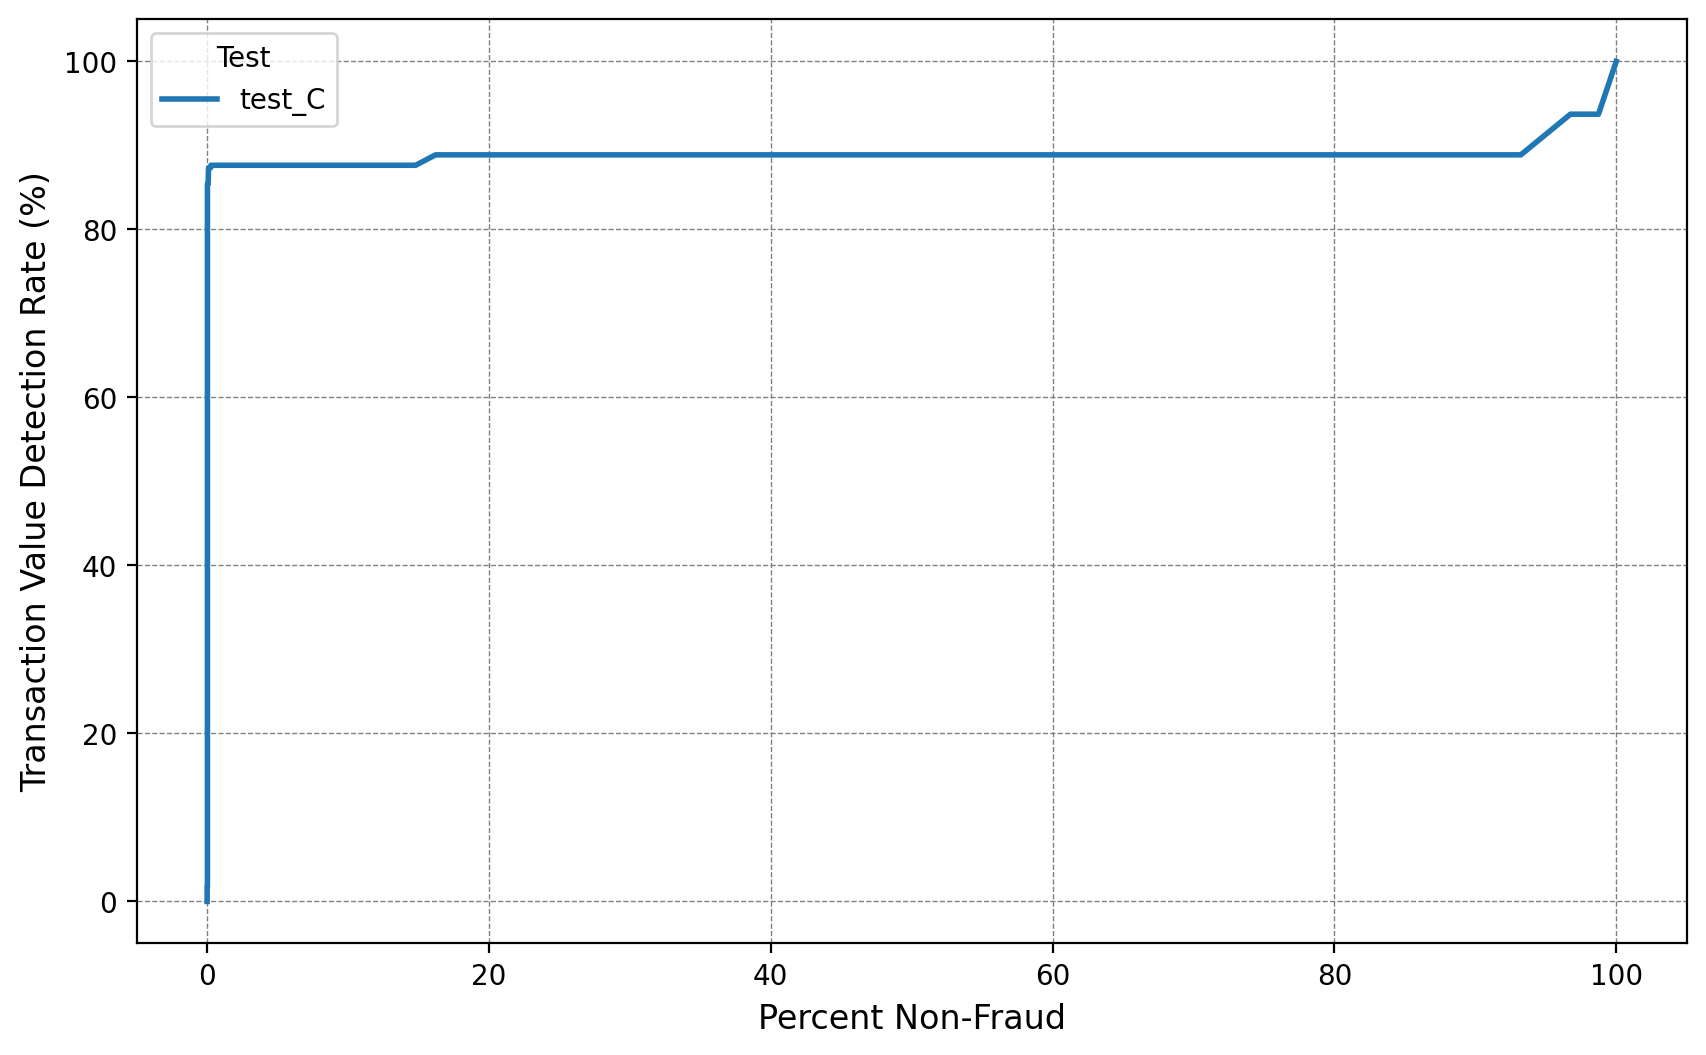

In [14]:
tvdr_pNF = plot_roc_NNet(TVDR, pNF, xlabel='Percent Non-Fraud', ylabel='Transaction Value Detection Rate (%)', f1=blindholdoutFile, legend=trainOrTest)

##### ADR vs A%NF

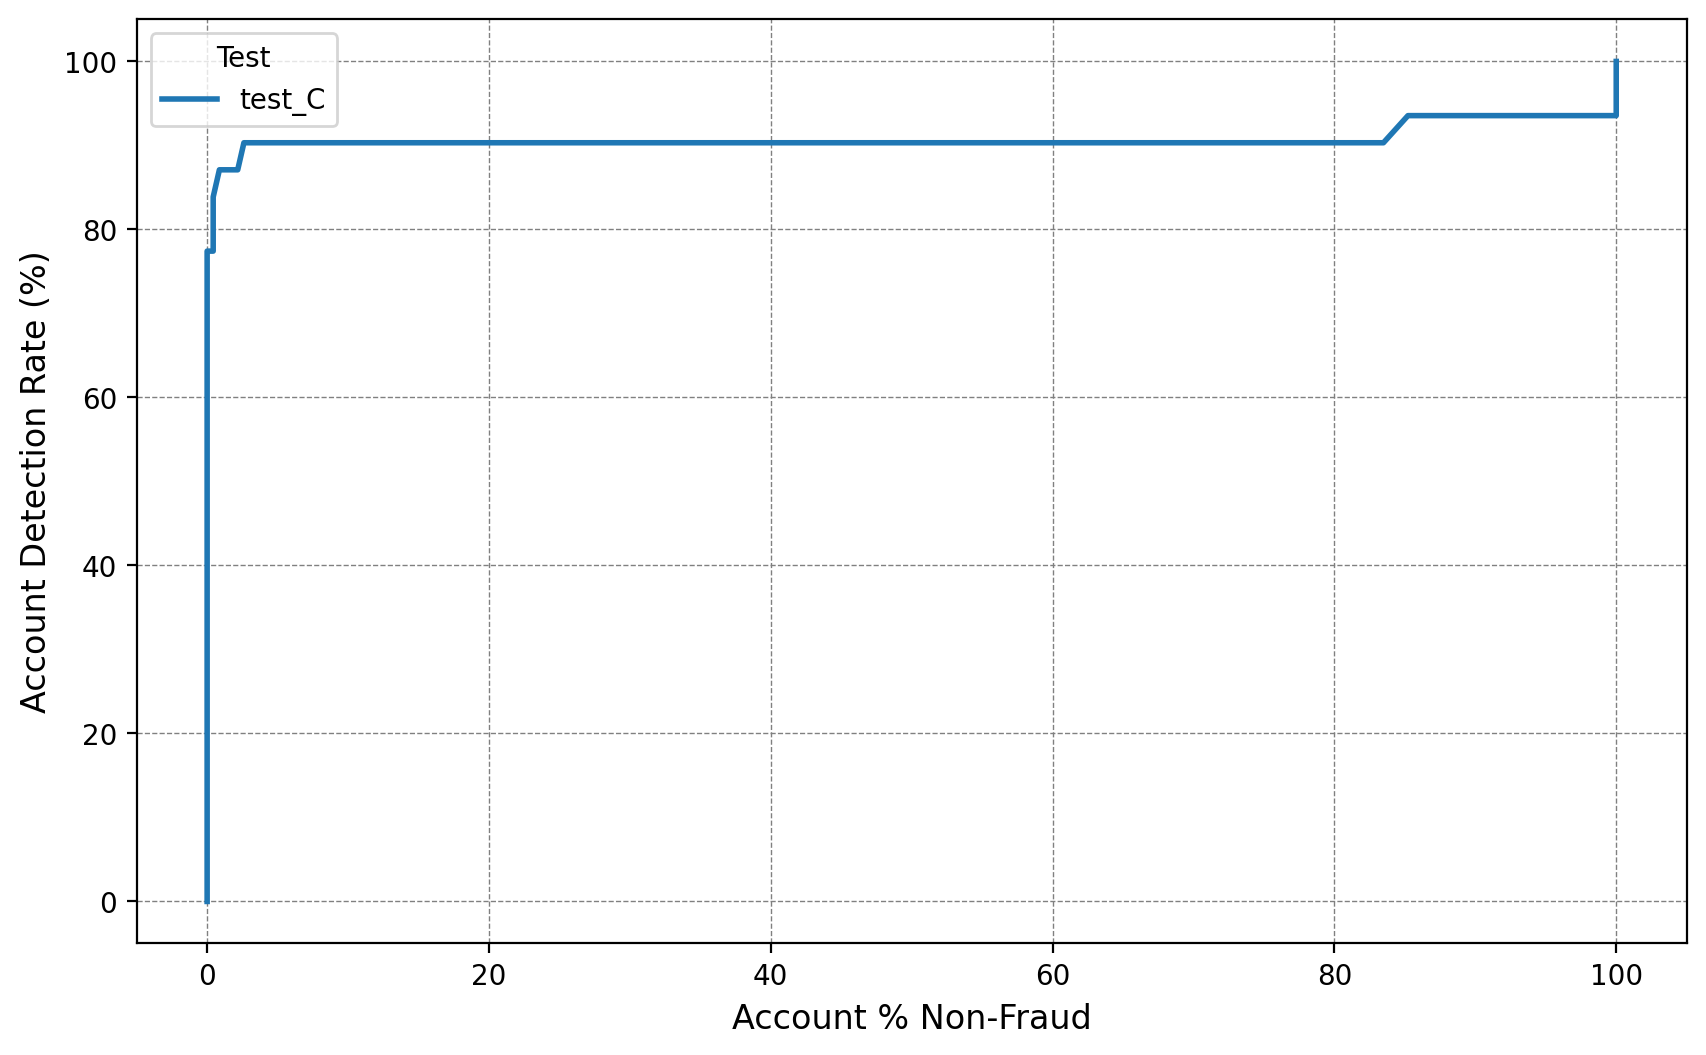

In [15]:
adr_afpr = plot_roc_NNet(ADR, ApNF, xlabel='Account % Non-Fraud', ylabel='Account Detection Rate (%)', f1=blindholdoutFile, legend=trainOrTest)

##### RTVDR vs A%NF

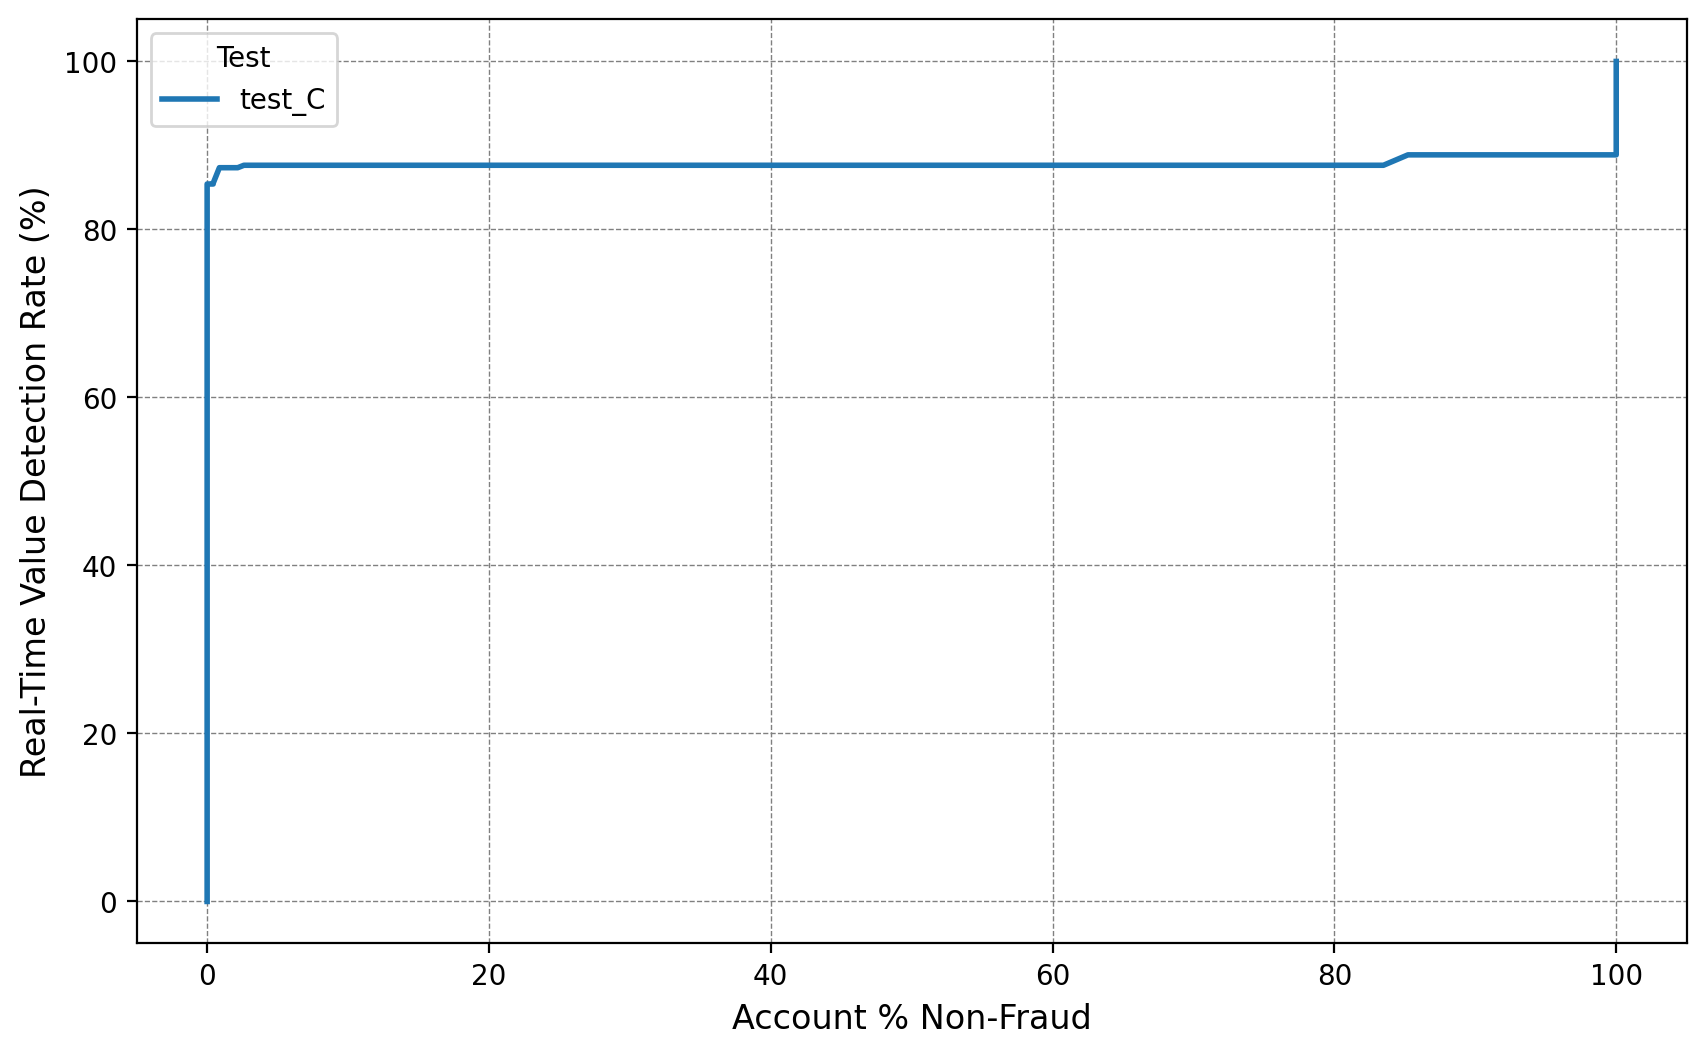

In [16]:
rtvdr_apnf = plot_roc_NNet(RTVDR, ApNF, xlabel='Account % Non-Fraud', ylabel='Real-Time Value Detection Rate (%)', f1=blindholdoutFile, legend=trainOrTest)

### Score Distribution Plot

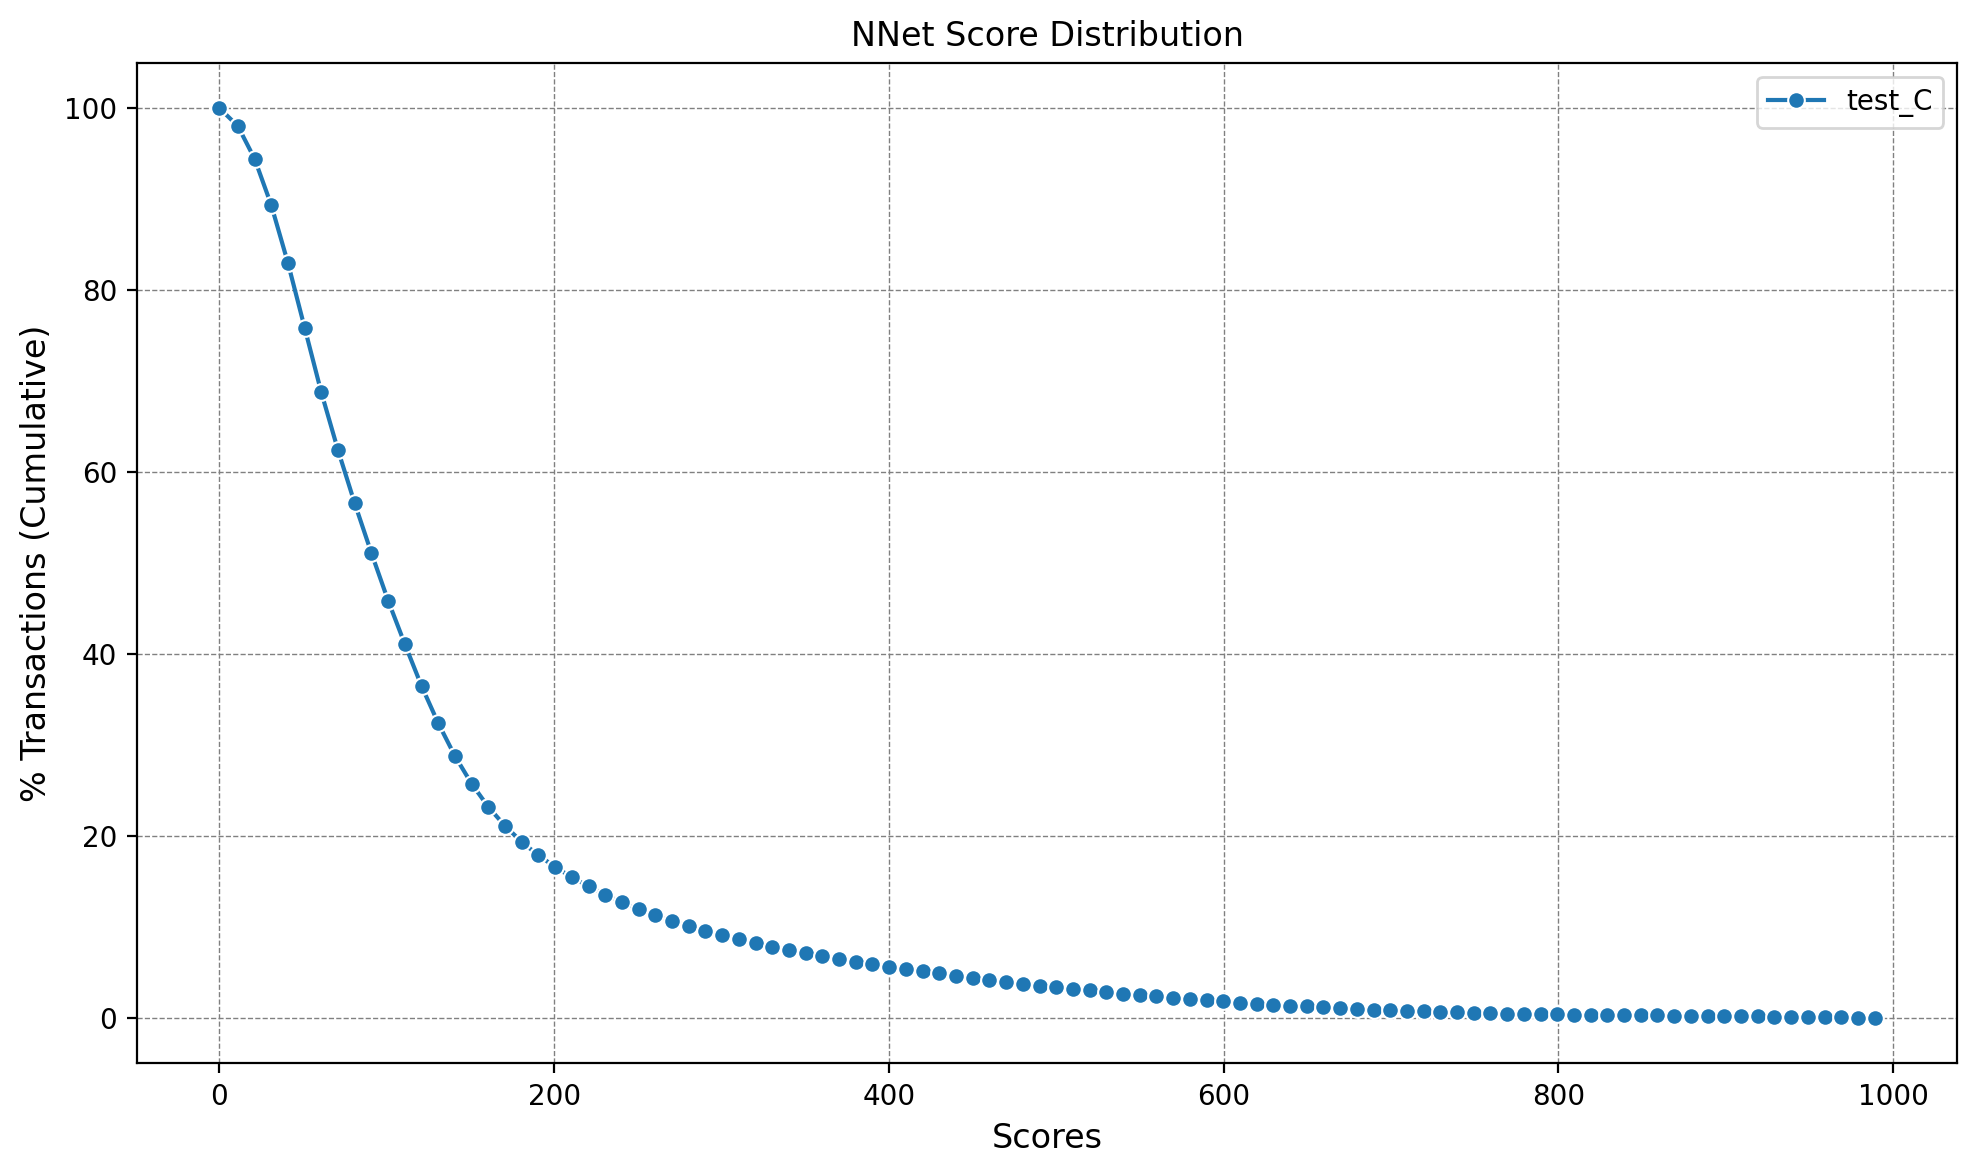

In [17]:
plot_scoreDist_NNet(df_test[df_test['is_train']==0], f1=blindholdoutFile)

# Aside from plots, make statements like the following

- Our model captured X% Fraud Transactions and prevented Y% Fraud Loss at a 0.5% NF review rate
- Our model captured X% Fraud Accounts and prevented Y% Fraud Loss at a 1% NF Account review rate

Recall, **Review Rate** is the Total # of Accounts with score >= Score Threshold divided by the Total # of Accounts. From a buisness persepctive, its not feasible to review all False Positives (FPs), so there is a trade off. The goal is to get the least amount of FPs but have the highest amount of True Positive (TPs).

Be sure to understand the meaning of what you're stating. Its fair game to be questioned, in detail, on any statements you claim.

## Understanding the Lists Produced from calcMetrics

The variable called **threshold_list** is a list of all the thresholds that calcMetrics will calculate the metrics for. If **threshold_list** is [0, 5, 10, 15, 20], then it has 5 elements, (i.e., len(threshold_list)=5). This means, the lists' outputted from calcMetrics (i.e., pNF, TDR, TVDR, ApNF, ADR, RTVDR), will each have 5 elements, where each elements values will correspond to the respected threshold value in **threshold_list**.

Here is an example, using index numbers, to help understand the values produced. Say, **threshold_list** = [0, 5, 10, 15, 20]. Index value of 0 corresponds to the list value 0, index value of 1 corresponds to the list value of 5, index value of 2 corresponds to the list value of 10, etc. In code form:
- threshold_list[0] is 0
- threshold_list[1] is 5
- threshold_list[2] is 10
- threshold_list[3] is 15
- threshold_list[4] is 20

When calcMetrics is called, it sequentially processes each element in **threshold_list**, one at a time. The pNF, TDR, TVDR, ApNF, ADR, RTVDR values, specific to the elements threshold value, are generated and stored to their respective lists.

The above needs to be understood so that you can produce the types of statements provided above. To get the TDR and TVDR values at a 0.5% NF review rate, you need to find the index value of 0.5 in the pNF list. Similary, to get the ADR and RTVDR values at a 1% NF review rate, you need to find the index value of 1 in the ApNF list. Below are example codes that can help.

In [18]:
def find_closest_index(lst, target):
    # Use the `min` function with a custom key to find the closest value
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

In [19]:
# Check the values in pNF, but keep in mind we want the index of the pNF value closest to 0.5
pNF

[100.0,
 98.74,
 96.75,
 93.23,
 88.85,
 84.98,
 80.97,
 77.08,
 72.86,
 67.98,
 63.47,
 59.43,
 55.71,
 52.27,
 48.77,
 45.87,
 43.1,
 40.4,
 38.02,
 35.81,
 33.56,
 30.98,
 28.48,
 26.82,
 25.08,
 22.95,
 21.24,
 19.28,
 17.72,
 16.21,
 14.8,
 13.75,
 12.49,
 11.75,
 10.81,
 10.14,
 9.32,
 8.6,
 8.05,
 7.48,
 7.09,
 6.62,
 6.27,
 5.9,
 5.55,
 5.15,
 4.81,
 4.44,
 4.24,
 4.09,
 3.92,
 3.67,
 3.42,
 3.37,
 3.22,
 3.07,
 2.92,
 2.8,
 2.7,
 2.58,
 2.4,
 2.26,
 2.16,
 1.93,
 1.83,
 1.71,
 1.61,
 1.49,
 1.49,
 1.44,
 1.36,
 1.34,
 1.29,
 1.16,
 1.14,
 1.14,
 1.09,
 1.09,
 1.07,
 1.02,
 0.94,
 0.82,
 0.82,
 0.77,
 0.74,
 0.74,
 0.69,
 0.64,
 0.59,
 0.59,
 0.59,
 0.59,
 0.59,
 0.57,
 0.57,
 0.57,
 0.55,
 0.52,
 0.52,
 0.5,
 0.42,
 0.37,
 0.37,
 0.37,
 0.37,
 0.37,
 0.37,
 0.35,
 0.35,
 0.35,
 0.32,
 0.32,
 0.32,
 0.27,
 0.25,
 0.2,
 0.2,
 0.2,
 0.17,
 0.17,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.12,
 0.12,
 0.1,
 0.1,
 0.1,
 0.1,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,
 0.07,


In [20]:
# Then get the index so you can use that index to get the values in TDR and TVDR at that pNF value
idx_pNF = find_closest_index(pNF, 0.5)
print(f'NF review rate = {pNF[idx_pNF]}% at idx = {idx_pNF}')

NF review rate = 0.5% at idx = 99


In [21]:
# Now you can use the index to generate your results
print(f'Our model captured {TDR[idx_pNF]}% Fraud Transactions and prevented {TVDR[idx_pNF]}% Fraud Loss at a {pNF[idx_pNF]}% NF review rate')

Our model captured 91.18% Fraud Transactions and prevented 87.64% Fraud Loss at a 0.5% NF review rate


In [22]:
# Check the values in ApNF, but keep in mind we want the index of the ApNF value closest to 1
ApNF

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.13,
 99.13,
 98.7,
 98.7,
 97.39,
 97.39,
 97.39,
 96.96,
 96.52,
 96.52,
 96.52,
 96.09,
 95.65,
 95.65,
 94.78,
 94.78,
 93.48,
 93.04,
 93.04,
 92.61,
 91.3,
 90.0,
 87.83,
 86.09,
 85.22,
 83.48,
 81.3,
 78.26,
 76.52,
 75.65,
 73.91,
 72.17,
 69.57,
 66.96,
 64.35,
 61.3,
 60.0,
 56.52,
 56.09,
 53.48,
 51.3,
 48.7,
 46.52,
 45.22,
 43.91,
 40.43,
 38.7,
 35.65,
 35.22,
 33.04,
 32.17,
 30.43,
 28.26,
 28.26,
 26.52,
 24.78,
 22.17,
 21.3,
 18.26,
 17.83,
 17.39,
 15.65,
 14.78,
 14.78,
 14.35,
 14.35,
 13.91,
 13.48,
 12.61,
 12.61,
 12.61,
 11.74,
 11.3,
 10.87,
 10.43,
 9.57,
 7.83,
 7.83,
 7.83,
 7.39,
 7.39,
 6.96,
 5.65,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 5.22,
 4.35,
 4.35,
 4.35,
 3.91,
 3.91,
 3.91,
 3.48,
 3.04,
 3.04,
 3.04,
 2.61,
 2.61,
 2.61,
 2.61,
 2.17,
 2.17,
 2.17,
 1.74,
 1.74,
 1.74,
 1.74,
 1.3,
 1.3,
 1.3,
 1.3,
 1.3,
 1.3,
 1.3,
 1.3,
 1.3,
 0.87,
 0.87,
 0.87,
 0.87,
 0.

In [23]:
# Then get the index so you can use that index to get the values in ADR and RTVDR at that ApNF value
idx_ApNF = find_closest_index(ApNF, 1)
print(f'NF Account review rate = {ApNF[idx_ApNF]}% at idx = {idx_ApNF}')

NF Account review rate = 0.87% at idx = 130


In [24]:
# Now you can use the index to generate your results
print(f'Our model captured {ADR[idx_ApNF]}% Fraud Account and prevented {RTVDR[idx_ApNF]}% Fraud Loss at a {ApNF[idx_ApNF]}% NF Account review rate')

Our model captured 87.1% Fraud Account and prevented 87.35% Fraud Loss at a 0.87% NF Account review rate
